# Курсовой проект

## Описание проекта
**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

## Обзор данных<a class="anchor" id="course_project_review"></a>
**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - кредитный рейтинг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [402]:
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV

%matplotlib inline
warnings.filterwarnings('ignore')

**Пути к директориям и файлам**

In [403]:
TRAIN_DATASET_PATH = './kaggle/train.csv'
TEST_DATASET_PATH = './kaggle/test.csv'

In [404]:
tfull = pd.read_csv(TRAIN_DATASET_PATH)
train_full = tfull.copy()

In [405]:
# N = 5000
# #train
# train_full = tfull.iloc[:N,:].copy()
# #test
# test_full = tfull.iloc[N:,:-1].copy()
# #key ans
# test_full_ans = tfull.iloc[N:,-1].copy()

# display(train_full.shape)
# display(test_full.shape)

In [406]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = train_full.columns.drop(TARGET_NAME).tolist()
# TEST_BASE_FEATURE_NAMES = test_full.columns.tolist()
NEW_FEATURE_NAMES = train_full.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)

In [407]:
train_full.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,7500.0,3.749500e+03,2.165208e+03,0.0,1874.75,3749.5,5624.25,7.499000e+03
Annual Income,5943.0,1.366392e+06,8.453392e+05,164597.0,844341.00,1168386.0,1640137.00,1.014934e+07
Tax Liens,7500.0,3.013333e-02,2.716035e-01,0.0,0.00,0.0,0.00,7.000000e+00
Number of Open Accounts,7500.0,1.113093e+01,4.908924e+00,2.0,8.00,10.0,14.00,4.300000e+01
Years of Credit History,7500.0,1.831747e+01,7.041946e+00,4.0,13.50,17.0,21.80,5.770000e+01
Maximum Open Credit,7500.0,9.451537e+05,1.602622e+07,0.0,279229.50,478159.0,793501.50,1.304726e+09
Number of Credit Problems,7500.0,1.700000e-01,4.985978e-01,0.0,0.00,0.0,0.00,7.000000e+00
Months since last delinquent,3419.0,3.469260e+01,2.168881e+01,0.0,16.00,32.0,50.00,1.180000e+02
Bankruptcies,7486.0,1.171520e-01,3.471917e-01,0.0,0.00,0.0,0.00,4.000000e+00
Current Loan Amount,7500.0,1.187318e+07,3.192612e+07,11242.0,180169.00,309573.0,519882.00,1.000000e+08


In [408]:
train_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Id                            7500 non-null   int64  
 1   Home Ownership                7500 non-null   object 
 2   Annual Income                 5943 non-null   float64
 3   Years in current job          7129 non-null   object 
 4   Tax Liens                     7500 non-null   float64
 5   Number of Open Accounts       7500 non-null   float64
 6   Years of Credit History       7500 non-null   float64
 7   Maximum Open Credit           7500 non-null   float64
 8   Number of Credit Problems     7500 non-null   float64
 9   Months since last delinquent  3419 non-null   float64
 10  Bankruptcies                  7486 non-null   float64
 11  Purpose                       7500 non-null   object 
 12  Term                          7500 non-null   object 
 13  Cur

### Проверка значений базовых признаков
Функция _check_feature_values(df)_ выводит информацию о типе данных признака, количество пропусков, уникальные значения, определяет возможность преобразования float &#8594; int

In [409]:
def check_feature_values(df):
    FEATURE_NAMES = BASE_FEATURE_NAMES
    dataset_size = df.index.size
    features_to_int = []
    features_with_nans = {}
    features_binary = []
    features_dummies = []
    for feature in FEATURE_NAMES:
        non_nan_count = df[feature].count()
        unique_values = df[feature].unique()
        if len(unique_values) > 20:
            unique_values_str = str(unique_values[:5]) + ' ... ' + str(unique_values[len(unique_values) - 5:])
        else:
            unique_values_str = str(unique_values)
        print(f"\033[1m{feature}\033[0m")
        print(f"\t\033[1mUnique values:\033[0m\n\t{unique_values_str}")
        print(f"\t\033[1mFeature not NaN size:\033[0m {non_nan_count}")
        print(f"\t\033[1mType of values:\033[0m {df.dtypes[feature]}")
        if non_nan_count == dataset_size:
            print(f"\033[95mПропусков нет\033[0m")
        elif non_nan_count / dataset_size > 0.9:
            print(f"\033[95mНемного пропусков\033[0m {dataset_size - non_nan_count}")
        else:
            print(f"\033[95mМного пропусков\033[0m {dataset_size - non_nan_count}")

        # Проверка float-значений на целые.
        # Если тип float, но при этом дробные части всех элементов равны 0, можно преобразовать в int
        int_flag = True

        if df.dtypes[feature] == np.float64 and dataset_size == non_nan_count:
            for i in df[feature]:
                try:      
                    if not pd.isna(i) and i != int(i):
                        int_flag = False
                        break
                except:
                    int_flag = False
        else:
            int_flag = False
        if int_flag:
            print(f"\033[92mПреобразовать в INT\033[0m")
            features_to_int.append(feature)

        # Формирование словаря признаков с пропусками
        if dataset_size != non_nan_count:
            features_with_nans[feature] = dataset_size - non_nan_count

        # Если признак состоит из 2 значений типа object, можно заменить их на 0 и 1
        if df.dtypes[feature] == np.object and len(unique_values) == 2:
            features_binary.append(feature)
            print(f"\033[94mПреобразовать значения категориального признака {feature} в 0 и 1\033[0m")
        if df.dtypes[feature] == np.object and len(unique_values) > 2:
            features_dummies.append(feature)
        print('*' * 50)
    return features_with_nans, features_to_int, features_binary, features_dummies

In [410]:
# Тренировочный датасет
train_pass_features, train_features_to_int, train_features_binary, train_features_dummies = check_feature_values(train_full)

Id
	Unique values:
	[0 1 2 3 4] ... [7495 7496 7497 7498 7499]
	Feature not NaN size: 7500
	Type of values: int64
Пропусков нет
**************************************************
Home Ownership
	Unique values:
	['Own Home' 'Home Mortgage' 'Rent' 'Have Mortgage']
	Feature not NaN size: 7500
	Type of values: object
Пропусков нет
**************************************************
Annual Income
	Unique values:
	[ 482087. 1025487.  751412.  805068.  776264.] ... [5327372. 1368000. 2833185. 1257610.  402192.]
	Feature not NaN size: 5943
	Type of values: float64
Много пропусков 1557
**************************************************
Years in current job
	Unique values:
	[nan '10+ years' '8 years' '6 years' '7 years' '5 years' '1 year'
 '< 1 year' '4 years' '3 years' '2 years' '9 years']
	Feature not NaN size: 7129
	Type of values: object
Немного пропусков 371
**************************************************
Tax Liens
	Unique values:
	[0. 3. 1. 2. 4. 6. 5. 7.]
	Feature not NaN size: 7500
	Ty

### Обзор целевого признака

In [411]:
train_full[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

Данные разбалансированы

## Преобразование признаков

### Изменение типа признаков на int

Функция *f_features_to_int* преобразует признаки из списка features_to_int к типу int:

In [412]:
def f_features_to_int(df, df_name, features_to_int):
    print(f"\tПреобразование типа признаков для датасета \033[1m{df_name}\033[0m:")
    for feature in features_to_int:
        try:
            df[feature] = df[feature].astype(int)
            print(f"Значения признака \033[1m{feature}\033[0m преобразованы в int")
        except:
            print(f"Проблема с признаком {feature}:\n {i}")

In [413]:
f_features_to_int(train_full, 'train_full', train_features_to_int)

	Преобразование типа признаков для датасета train_full:
Значения признака Tax Liens преобразованы в int
Значения признака Number of Open Accounts преобразованы в int
Значения признака Maximum Open Credit преобразованы в int
Значения признака Number of Credit Problems преобразованы в int
Значения признака Current Loan Amount преобразованы в int
Значения признака Current Credit Balance преобразованы в int
Значения признака Monthly Debt преобразованы в int


### Изменение значений признаков

#### Признак "Years in current job" 

Признак "Years in current job" обладает числовыми значениями, но в каждом значении присутствует слово "year(s)". Предлагается оставить только числовые значения. Строки со значениями "10+ years" и  "< 1 year" преобразовать в 10 и 0

Функция _replace_year_to_num_ преобразовывает категориальные значения признака "Years in current job" в числовые int:

In [414]:
def replace_year_to_num(df):
    df.replace({'Years in current job': {
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2, 
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10      
}}, inplace=True)

Преобразование признака "Years in current job" для обоих датасетов:

In [415]:
replace_year_to_num(train_full)

### Проверка выбросов

**Функция _plot_outliers_ распечатывает 3 графика для каждого признака:**
 - ЯОП (KDE) обоих датасетов
 - Ящик с усами (BoxPlot) тренировачного датасета
 - Ящик с усами (BoxPlot) тестового датасета

In [416]:
def plot_outliers(df_tr, col_n):
# def plot_outliers(df_tr, df_te, col_n):
#     fig, ax = plt.subplots(1, 2, figsize=(16,5))
#     ax[0].set_title(f'KDE for both datasets on {col_n}')
#     plt.set_title('Train Dataset')
#     ax[2].set_title('Test Dataset')
#     df_tr[col_n].plot.kde(color='#628cbf', ax=ax[0])
#     df_te[col_n].plot.kde(color='#c95556', ax=ax[0])
    sns.boxplot(data=df_tr, x=col_name, color='#628cbf')
#     sns.boxplot(data=df_te, x=col_name, color='#c95556', ax=ax[2])
    plt.show()

In [417]:
cont_cols = [
    'Annual Income',
    'Years in current job',
    'Tax Liens',
    'Number of Open Accounts',
    'Years of Credit History',
    'Maximum Open Credit',
    'Number of Credit Problems',
    'Months since last delinquent',
    'Current Loan Amount',
    'Current Credit Balance',
    'Credit Score']

cat_cols =['Home Ownership',
           'Bankruptcies',
           'Purpose',
           'Term']

TARGET = ['Credit Default']

# for col_name in cont_cols:
#     plot_outliers(train_full, col_name)
    
#     plot_outliers(train_full, test_full, col_name)

#### Выводы из визуального анализа:
* В целом графики KDE похожи
* Возможно есть выбросы сверху, особо заметные из них:
    * В признаке **'Current Loan Amount'** есть много одинаковых больших значений
    * В признаке **'Credit Score'** есть много одинаковых больших значений
    
Рассмотрим каждый из пунктов по отдельности

### Обработка выбросов<a class="anchor" id="outliers"></a>

#### Признак "Current Loan Amount"

In [418]:
print(train_full.loc[(train_full["Current Loan Amount"] == 99999999), :].shape)

(870, 18)


Данный признак имеет много значений 99999999, скорее всего это выброс (ближайшее значение меньше 800000). Заменим эти значения медианными

In [419]:
train_full.loc[train_full['Current Loan Amount'] == 99999999, 'Current Loan Amount'] = train_full['Current Loan Amount'].median()

Проверим результат замены:

In [420]:
print(train_full.loc[(train_full["Current Loan Amount"] == 99999999), :].shape)

(0, 18)


#### Признак "Credit Score"

In [421]:
print(train_full.loc[(train_full["Credit Score"] > 850 ), "Credit Score"].shape)

(400,)


Данный признак имеет много значений больше 850 (850 - максимальный кредитный рейтинг по всем найденным шкалам). Все такие значения больше 6000, скорее всего это выброс. Проверим эти значения:

In [422]:
train_full.loc[(train_full["Credit Score"] > 6000 ), "Credit Score"].head()

69     6470.0
87     7440.0
94     7010.0
96     7320.0
116    7390.0
Name: Credit Score, dtype: float64

Замечено, что многие значения оканчиваются на 0. Возможно он лишний, проверим все выбросные значения.
Функция _check_credit_score_outliers_ проверяет значения выбросов, б**о**льших 850. Предполагается, что в эти значения дописан лишний 0:

In [423]:
def check_credit_score_outliers(df):
    x = []
    for i in df.loc[(df["Credit Score"] > 850 ), "Credit Score"]:
        if i % 10 != 0:
            x.append(i)
    print(len(x))

In [424]:
check_credit_score_outliers(train_full)

0


 Таким образом, все выбросные значения оканчиваются на 0. Поделим все эти значения на 10:

In [425]:
train_full.loc[train_full['Credit Score'] > 850, 'Credit Score'] = train_full.loc[train_full['Credit Score'] > 850, 'Credit Score'] / 10

In [426]:
train_full.loc[(train_full["Credit Score"] > 850 ), "Credit Score"].count()

0

#### Остальные признаки

In [427]:
from collections import Counter
def check_outliers(df, n, features):
    outlier_idxs = [] 
    for col in features:
        # 25%
        q1 = np.percentile(df[col], 25)
        # 75%
        q3 = np.percentile(df[col], 75)
        # IQR
        outlier_step = 1.5 * (q3 - q1)
        
        # Определение индексов с отклонениями
        outlier_list_col = df[(df[col] < q1 - outlier_step) | (df[col] > q3 + outlier_step )].index
        
        # Добавить найденные индексы в общий список
        outlier_idxs.extend(outlier_list_col)
        
    # Выбрать наблюдения, содержащие более n отклонений
    outlier_idxs = Counter(outlier_idxs)        
    multiple_outliers = [k for k, v in outlier_idxs.items() if v > n]
    
    return multiple_outliers

In [428]:
outliers_to_drop = check_outliers(train_full, 2, cont_cols)

In [429]:
len(outliers_to_drop)

110

Удаление выбросных строк:

In [430]:
train_full = train_full.drop(outliers_to_drop, axis=0).reset_index(drop=True)

In [431]:
train_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7390 entries, 0 to 7389
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Id                            7390 non-null   int64  
 1   Home Ownership                7390 non-null   object 
 2   Annual Income                 5857 non-null   float64
 3   Years in current job          7027 non-null   float64
 4   Tax Liens                     7390 non-null   int64  
 5   Number of Open Accounts       7390 non-null   int64  
 6   Years of Credit History       7390 non-null   float64
 7   Maximum Open Credit           7390 non-null   int64  
 8   Number of Credit Problems     7390 non-null   int64  
 9   Months since last delinquent  3373 non-null   float64
 10  Bankruptcies                  7376 non-null   float64
 11  Purpose                       7390 non-null   object 
 12  Term                          7390 non-null   object 
 13  Cur

Проверим описательные характеристики после проведенных преобразований:

In [432]:
train_full.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,7390.0,3.752467e+03,2.165992e+03,0.0,1877.25,3752.5,5628.75,7.499000e+03
Annual Income,5857.0,1.345257e+06,8.125916e+05,164597.0,839610.00,1161983.0,1620662.00,1.014934e+07
Years in current job,7027.0,5.860680e+00,3.616993e+00,0.0,3.00,6.0,10.00,1.000000e+01
Tax Liens,7390.0,2.530447e-02,2.418710e-01,0.0,0.00,0.0,0.00,6.000000e+00
Number of Open Accounts,7390.0,1.102801e+01,4.791232e+00,2.0,8.00,10.0,14.00,4.300000e+01
Years of Credit History,7390.0,1.818743e+01,6.923227e+00,4.0,13.50,17.0,21.70,5.770000e+01
Maximum Open Credit,7390.0,8.767005e+05,1.584048e+07,0.0,276540.00,472538.0,779108.00,1.304726e+09
Number of Credit Problems,7390.0,1.654939e-01,4.817134e-01,0.0,0.00,0.0,0.00,6.000000e+00
Months since last delinquent,3373.0,3.470679e+01,2.167864e+01,0.0,16.00,32.0,50.00,1.180000e+02
Bankruptcies,7376.0,1.175434e-01,3.472097e-01,0.0,0.00,0.0,0.00,4.000000e+00


In [433]:
# for col_name in cont_cols:
#     plot_outliers(train_full, col_name)

## Обработка пропусков

### Признаки с пропусками

In [434]:
print(f"TRAIN:\n{train_pass_features}")

TRAIN:
{'Annual Income': 1557, 'Years in current job': 371, 'Months since last delinquent': 4081, 'Bankruptcies': 14, 'Credit Score': 1557}


#### Признаки 'Annual Income', ' Credit Score', 'Years in current job', 'Bankruptcies'
Признаки Annual Income' и 'Credit Score' имеют пропуски в одинаковых позициях:

In [435]:
train_annual_income_nan_idx = train_full.index[train_full['Annual Income'].isna()]
train_credit_score_nan_idx = train_full.index[train_full['Credit Score'].isna()]
if sorted(train_annual_income_nan_idx) == sorted(train_credit_score_nan_idx):
    print('ID совпадают')

ID совпадают


Заполним пропуски признаков 'Annual Income', 'Credit Score', 'Years in current job' медианными значениями, 'Bankruptcies' - модой:

In [436]:
# Медианы
annual_income_median = train_full['Annual Income'].median()
credit_score_median = train_full['Credit Score'].median()
years_in_current_job_median = train_full['Years in current job'].median()
# bankruptcies_mode = train_full['Bankruptcies'].mode()

In [437]:
# Замена
train_full.loc[train_full['Annual Income'].isna(), 'Annual Income'] = annual_income_median
train_full.loc[train_full['Credit Score'].isna(), 'Credit Score'] = credit_score_median
train_full.loc[train_full['Years in current job'].isna(), 'Years in current job'] = years_in_current_job_median
# train_full.loc[train_full['Bankruptcies'].isna(), 'Bankruptcies'] = bankruptcies_mode
train_full['Bankruptcies'].fillna(train_full['Bankruptcies'].mode().iloc[0], inplace=True)

#### Признак "Bankruptcies"
Предполагается, что признак "Bankruptcies" категориальный, преобразуем его тип в object

In [438]:
# train_full["Bankruptcies"] = train_full["Bankruptcies"].astype(int)
train_full["Bankruptcies"] = train_full["Bankruptcies"].astype(object)

Попробовать регрессию  
**--- TODO_2 ---**

#### Признак 'Months since last delinquent'
Данный имеет пропуски более чем 50%
1) попробуем удалить этот признак  
2) предположим, что пропуски - это отсутсвие просрочек, заменим пропуски большими значениями, например, 1200  
3) учтем признак 'Number of Credit Problems'  

In [439]:
# 1)

In [440]:
#train_full.drop(['Months since last delinquent'], axis=1, inplace=True)
#cont_cols.remove('Months since last delinquent')

In [441]:
# 2)

In [442]:
train_full.loc[train_full['Months since last delinquent'].isna(), 'Months since last delinquent'] = 0

In [443]:
# 3)
#train_full.loc[train_full['Months since last delinquent'].isna(), ['Number of Credit Problems', 'Months since last delinquent']]

Проверка пропусков после их удаления в обоих датасетах:

In [444]:
print(f'Число пропусков в TRAIN:\n{train_full.isna().sum().sum()}')

Число пропусков в TRAIN:
0


### Преобразование категориальных признаков в dummies

#### Преобразование значений категориальных признаков, имеющих только 2 значения, в 0 и 1. 

In [445]:
train_full.replace({'Term': {'Short Term': 0, 'Long Term': 1}}, inplace=True)
print(f"Значения признака \033[1mTerm\033[0m преобразованы в 0 и 1")

Значения признака Term преобразованы в 0 и 1


In [446]:
cat_cols.remove('Term')
cont_cols.append('Term')
cat_cols

['Home Ownership', 'Bankruptcies', 'Purpose']

#### Преобразование значений категориальных признаков, имеющих более 2 значений

In [447]:
def cat_to_dummies(df):
#     print(df)
    for feature in df.select_dtypes(include='object').columns:
        df = pd.concat([df, pd.get_dummies(df[feature], prefix=feature)], axis=1)
        print(f"Значения признака \033[1m{feature}\033[0m преобразованы в DUMMIES")
    return df

In [448]:
train_full_dum = cat_to_dummies(train_full)

Значения признака Home Ownership преобразованы в DUMMIES
Значения признака Bankruptcies преобразованы в DUMMIES
Значения признака Purpose преобразованы в DUMMIES


### Удаление лишних признаков

In [449]:
TRAIN_FEATURES_NAMES = train_full.columns
TRAIN_FEATURES_NAMES_DUM = train_full_dum.columns
features_to_delete = ['Id', 'Purpose', 'Bankruptcies', 'Home Ownership', TARGET_NAME]
for feature in features_to_delete:
    TRAIN_FEATURES_NAMES_DUM = TRAIN_FEATURES_NAMES_DUM.drop(feature)

In [450]:
TRAIN_FEATURES_NAMES = TRAIN_FEATURES_NAMES.drop(TARGET_NAME)
TRAIN_FEATURES_NAMES = TRAIN_FEATURES_NAMES.drop('Id')

### Матрица корреляций

In [451]:
def correl_matrix(df):
    plt.figure(figsize = (25, 20))

    sns.set(font_scale=0.8)
    sns.heatmap(df[:].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

    plt.title('Матрица корреляции всех признаков')
    plt.show()

In [452]:
# correl_matrix(train_full)

## Подбор гиперпараметров

In [453]:
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score
from imblearn.over_sampling import SMOTE
import itertools
from imblearn.pipeline import Pipeline as SM_Pipeline
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import MinMaxScaler

### Нормализация данных<a class="anchor" id="normalization"></a>

In [454]:
def norm_stand_scal(df, num_features):
    scaler = StandardScaler()
#     df_norm = df.copy()
    df[num_features] = scaler.fit_transform(df[num_features])
    return df

### Разделение датасетов для обучения

In [455]:
def train_test_dev(df, features):
    X = df[features]
    y = df[TARGET_NAME]
    return train_test_split(X, y, shuffle=True, test_size=0.25)

### Балансировка целевого признака<a class="anchor" id="target_balancing"></a>

Функция _balance_df_by_target_ проводит балансировку

In [456]:
def balance_df_by_target(df, target_name):
    target_counts = df[target_name].value_counts()
#     print(target_counts)

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [457]:
def balancing(bal_x, bal_y):
    df_for_balancing = pd.concat([bal_x, bal_y], axis=1)
    df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    print(df_balanced[TARGET_NAME].value_counts())
    return df_balanced.drop(columns=TARGET_NAME), df_balanced[TARGET_NAME]

#  Создание и обучение модели

Функция _get_classification_report_ выдает отчет _classification_report_

In [458]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

## CatBoost (cat_features=cat_cols)

In [188]:
train_full_norm = norm_stand_scal(train_full, cont_cols)

In [189]:
X_train, X_test, y_train, y_test = train_test_dev(train_full_norm, TRAIN_FEATURES_NAMES)

In [190]:
X_train, y_train = balancing(X_train, y_train)

0    3983
1    3118
Name: Credit Default, dtype: int64


In [191]:
X_train[cat_cols] = X_train[cat_cols].astype(str)
X_test[cat_cols] = X_test[cat_cols].astype(str)

In [192]:
model_catb = catb.CatBoostClassifier(
    silent=True, 
    cat_features=cat_cols
)
model_catb.fit(X_train, y_train)
y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.91      0.89      3983
           1       0.87      0.83      0.85      3118

    accuracy                           0.87      7101
   macro avg       0.87      0.87      0.87      7101
weighted avg       0.87      0.87      0.87      7101

TEST

              precision    recall  f1-score   support

           0       0.79      0.79      0.79      1324
           1       0.47      0.46      0.46       524

    accuracy                           0.70      1848
   macro avg       0.63      0.63      0.63      1848
weighted avg       0.70      0.70      0.70      1848

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1049  275
1                283  241


#### Подбор гиперпараметров

In [194]:
params = {'n_estimators':[50, 100, 150, 250, 300], 
          'max_depth':[3, 5, 7, 10],
          'learning_rate':[0.001, 0.01, 0.05, 0.1]}

In [195]:
cv=KFold(n_splits=3, shuffle=True)

In [196]:
rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x7f172b87ef90>,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.05,
                                                          0.1],
                                        'max_depth': [3, 5, 7, 10],
                                        'n_estimators': [50, 100, 150, 250,
                                                         300]},
                   scoring='f1')

In [197]:
rs.best_params_

{'n_estimators': 150, 'max_depth': 10, 'learning_rate': 0.1}

In [198]:
rs.best_score_

0.6720230721855524

### Обучение и оценка модели

In [276]:
final_model = catb.CatBoostClassifier(
    n_estimators=150, 
    max_depth=10, 
    learning_rate=0.1, 
    cat_features=cat_cols,
    silent=True)

final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

## CatBoost (dummies)

In [459]:
train_full_norm = norm_stand_scal(train_full_dum, cont_cols)

In [460]:
X_train, X_test, y_train, y_test = train_test_dev(train_full_norm, TRAIN_FEATURES_NAMES_DUM)

In [461]:
X_train, y_train = balancing(X_train, y_train)

0    3967
1    3150
Name: Credit Default, dtype: int64


In [462]:
# X_train[cat_cols] = X_train[cat_cols].astype(str)
# X_test[cat_cols] = X_test[cat_cols].astype(str)

In [463]:
model_catb = catb.CatBoostClassifier(
    silent=True
)
calib = CalibratedClassifierCV(base_estimator=final_model, method='sigmoid', cv=2)

model_catb.fit(X_train, y_train)
calib.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      3967
           1       0.88      0.86      0.87      3150

    accuracy                           0.88      7117
   macro avg       0.88      0.88      0.88      7117
weighted avg       0.88      0.88      0.88      7117

TEST

              precision    recall  f1-score   support

           0       0.79      0.76      0.78      1340
           1       0.43      0.48      0.46       508

    accuracy                           0.69      1848
   macro avg       0.61      0.62      0.62      1848
weighted avg       0.70      0.69      0.69      1848

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1024  316
1                265  243


#### Подбор гиперпараметров

In [464]:
params = {'n_estimators':[50, 100, 150, 250, 300], 
          'max_depth':[3, 5, 7, 10],
          'learning_rate':[0.001, 0.01, 0.05, 0.1]}

In [465]:
cv=KFold(n_splits=3, shuffle=True)

In [466]:
rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x7f172955f550>,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.05,
                                                          0.1],
                                        'max_depth': [3, 5, 7, 10],
                                        'n_estimators': [50, 100, 150, 250,
                                                         300]},
                   scoring='f1')

In [469]:
rs.best_params_

{'n_estimators': 50, 'max_depth': 10, 'learning_rate': 0.1}

In [363]:
rs.best_score_

0.6630474888812682

### Обучение и оценка модели

In [470]:
final_model = catb.CatBoostClassifier(
    n_estimators=rs.best_params_['n_estimators'], 
    max_depth=rs.best_params_['max_depth'], 
    learning_rate=rs.best_params_['learning_rate'], 
    silent=True)

calib = CalibratedClassifierCV(base_estimator=final_model, method='sigmoid', cv=2)
final_model.fit(X_train, y_train)

calib.fit(X_train, y_train)
# print(final_model.predict_proba(X_train))
# print(calib.predict_proba(X_train))

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      3967
           1       0.89      0.85      0.87      3150

    accuracy                           0.89      7117
   macro avg       0.89      0.88      0.88      7117
weighted avg       0.89      0.89      0.89      7117

TEST

              precision    recall  f1-score   support

           0       0.79      0.79      0.79      1340
           1       0.45      0.46      0.45       508

    accuracy                           0.70      1848
   macro avg       0.62      0.62      0.62      1848
weighted avg       0.70      0.70      0.70      1848

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1060  280
1                276  232


### Выбор наиболее важных признаков

In [471]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (10, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

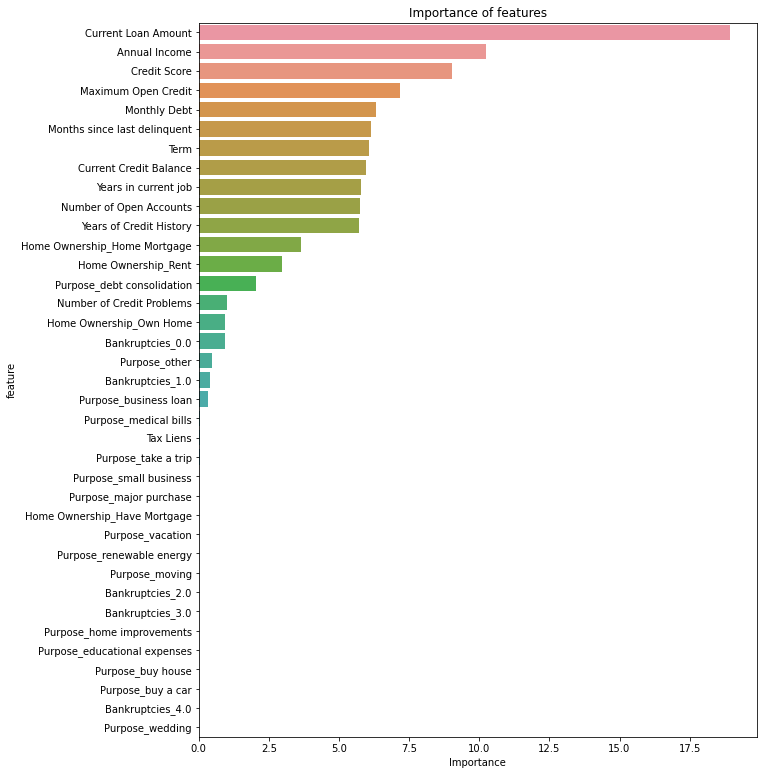

In [472]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=15)

In [473]:
# important_features_top

In [474]:
# final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=7, l2_leaf_reg=10, silent=True, random_state=123)
# final_model = catb.CatBoostClassifier(
#     n_estimators=500, 
#     max_depth=7, 
#     learning_rate=0.05, 
#     cat_features=cat_cols,
#     silent=True)
final_model.fit(X_train[important_features_top], y_train)

y_train_pred = final_model.predict(X_train[important_features_top])
y_test_pred = final_model.predict(X_test[important_features_top])
y_test_pred_probs = final_model.predict_proba(X_test[important_features_top])


get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.79      0.86      0.82      3967
           1       0.80      0.70      0.75      3150

    accuracy                           0.79      7117
   macro avg       0.79      0.78      0.79      7117
weighted avg       0.79      0.79      0.79      7117

TEST

              precision    recall  f1-score   support

           0       0.81      0.77      0.79      1340
           1       0.46      0.51      0.49       508

    accuracy                           0.70      1848
   macro avg       0.63      0.64      0.64      1848
weighted avg       0.71      0.70      0.71      1848

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1034  306
1                247  261


## Предсказания тестовых данных¶

In [475]:
test_full = pd.read_csv(TEST_DATASET_PATH)

In [476]:
test_full.shape

(2500, 17)

In [477]:
# Тестовый датасет
test_pass_features, test_features_to_int, test_features_binary, test_features_dummies = check_feature_values(test_full)

Id
	Unique values:
	[7500 7501 7502 7503 7504] ... [9995 9996 9997 9998 9999]
	Feature not NaN size: 2500
	Type of values: int64
Пропусков нет
**************************************************
Home Ownership
	Unique values:
	['Rent' 'Home Mortgage' 'Own Home' 'Have Mortgage']
	Feature not NaN size: 2500
	Type of values: object
Пропусков нет
**************************************************
Annual Income
	Unique values:
	[     nan  231838. 1152540. 1220313. 2340952.] ... [ 907839. 1020053. 1171806.  723520. 1694439.]
	Feature not NaN size: 1987
	Type of values: float64
Много пропусков 513
**************************************************
Years in current job
	Unique values:
	['4 years' '1 year' '3 years' '10+ years' '6 years' '5 years' '< 1 year'
 '2 years' '9 years' '8 years' '7 years' nan]
	Feature not NaN size: 2414
	Type of values: object
Немного пропусков 86
**************************************************
Tax Liens
	Unique values:
	[ 0.  1.  5.  4.  2.  6.  3. 15.]
	Feature n

### Изменение типа признаков на int

In [478]:
f_features_to_int(test_full, 'test_full', test_features_to_int)

	Преобразование типа признаков для датасета test_full:
Значения признака Tax Liens преобразованы в int
Значения признака Number of Open Accounts преобразованы в int
Значения признака Maximum Open Credit преобразованы в int
Значения признака Number of Credit Problems преобразованы в int
Значения признака Current Loan Amount преобразованы в int
Значения признака Current Credit Balance преобразованы в int
Значения признака Monthly Debt преобразованы в int


Преобразование признака "Years in current job" для тестового датасета:

In [483]:
replace_year_to_num(test_full)

In [484]:
test_full.loc[test_full['Current Loan Amount'] == 99999999, 'Current Loan Amount'] = test_full['Current Loan Amount'].median()

In [485]:
test_full.loc[test_full['Credit Score'] > 850, 'Credit Score'] = test_full.loc[test_full['Credit Score'] > 850, 'Credit Score'] / 10

In [486]:
print(f"TEST:\n{test_pass_features}")

TEST:
{'Annual Income': 513, 'Years in current job': 86, 'Months since last delinquent': 1358, 'Bankruptcies': 3, 'Credit Score': 513}


In [487]:
# Медианы
annual_income_median = test_full['Annual Income'].median()
credit_score_median = test_full['Credit Score'].median()
years_in_current_job_median = test_full['Years in current job'].median()

In [488]:
test_full.loc[test_full['Annual Income'].isna(), 'Annual Income'] = annual_income_median
test_full.loc[test_full['Credit Score'].isna(), 'Credit Score'] = credit_score_median
test_full.loc[test_full['Years in current job'].isna(), 'Years in current job'] = years_in_current_job_median
test_full['Bankruptcies'].fillna(test_full['Bankruptcies'].mode().iloc[0], inplace=True)

In [489]:
test_full["Bankruptcies"] = test_full["Bankruptcies"].astype(object)

In [490]:
# test_full.drop(['Months since last delinquent'], axis=1, inplace=True)
test_full.loc[test_full['Months since last delinquent'].isna(), 'Months since last delinquent'] = 0

In [491]:
print(f'Число пропусков в TEST:\n{test_full.isna().sum().sum()}')

Число пропусков в TEST:
0


In [492]:
test_full.replace({'Term': {'Short Term': 0, 'Long Term': 1}}, inplace=True)

In [493]:
test_full = cat_to_dummies(test_full)

Значения признака Home Ownership преобразованы в DUMMIES
Значения признака Bankruptcies преобразованы в DUMMIES
Значения признака Purpose преобразованы в DUMMIES


In [494]:
test_full.drop(['Home Ownership', 'Bankruptcies', 'Purpose'], axis=1, inplace=True)

In [495]:
test_full = norm_stand_scal(test_full, cont_cols)

In [496]:
# test_full[cat_cols] = test_full[cat_cols].astype(str)

In [497]:
# test_full = test_full[TRAIN_FEATURES_NAMES]
# test_full.info()

In [498]:
# Проводим предсказание на тестовых данных
TEST_FEATURES_NAMES_DUM = TRAIN_FEATURES_NAMES_DUM.drop('Purpose_renewable energy')
pred_test = final_model.predict(test_full[TEST_FEATURES_NAMES_DUM])

In [499]:
test_full[TARGET_NAME] = pred_test
test_full[TARGET_NAME] = test_full[TARGET_NAME].astype('int')

In [500]:
# Сохраняем полученные предсказания
# test_full.loc[:, ['Id', TARGET_NAME]].to_csv('./kaggle/damkkh_predictions_20201027_0827.csv', index=None)
test_full[['Id', TARGET_NAME]].to_csv('./kaggle/damkkh_predictions_20201028_0746.csv', index=False)